# KA Model vs NMM3D Lookup Table

This notebook tests the Kirchhoff Approximation (KA) model against NMM3D reference data.

## About the KA Model

The Kirchhoff Approximation (also known as Physical Optics or Geometric Optics approximation) is a high-frequency scattering model suitable for:

**Validity Conditions:**
- **Large-scale roughness**: k·σ > 0.3 (preferably > 1)
- **Large radius of curvature**: k·L > 6 (preferably > 10)
- **Moderate slopes**: Mean square slope (MSS) < 0.3

where:
- k = 2π/λ is the wavenumber
- σ is the RMS height
- L is the correlation length
- MSS ≈ 2(σ/L)² for exponential correlation

**Physical Interpretation:**
- KA models **specular reflection** from large-scale surface facets
- Best suited for **ocean waves** and **large-scale terrain**
- Predicts **zero cross-polarization** for monostatic backscatter (single-bounce)
- May underestimate backscatter compared to NMM3D for small-scale roughness

**Comparison with NMM3D:**
- NMM3D is a full-wave numerical method that includes all scattering mechanisms
- KA captures only the dominant specular component
- For surfaces outside KA validity range, consider:
  - **SPM** (Small Perturbation Method) for k·σ < 0.3
  - **IEM/AIEM** (Integral Equation Method) for intermediate roughness
  - **Two-scale models** (KA + Bragg) for realistic surfaces with multiple scales

**ACF Options:**
- `exponential`: Matches NMM3D correlation function
- `gaussian`: Smoother surfaces, faster spectral decay
- `xpower`: Generalized power-law correlation (α parameter)

In [1]:
import os
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from mwrtms.core import ElectromagneticWave, PolarizationState, ScatteringGeometry
from mwrtms.medium.surface import build_surface_from_statistics
from mwrtms.scattering.surface.ka import KAModel
from mwrtms.medium import HomogeneousMedium


NOTEBOOK_ROOT = Path.cwd().resolve()
DATA_DIR = NOTEBOOK_ROOT / "data"
if not DATA_DIR.exists():
    DATA_DIR = NOTEBOOK_ROOT.parent / "data"

MPL_CACHE = NOTEBOOK_ROOT / ".mpl-cache"
MPL_CACHE.mkdir(exist_ok=True)
os.environ.setdefault("MPLCONFIGDIR", str(MPL_CACHE))

LUT_PATH = DATA_DIR / "NMM3D_LUT_NRCS_40degree.dat"
if not LUT_PATH.exists():
    raise FileNotFoundError(f"NMM3D LUT not found at {LUT_PATH}")

# Simulation controls
FREQUENCY_GHZ = 5.405
INCIDENCE_DEG = 40.0
TARGET_RATIOS = [4, 7, 10, 15]

# KA Model controls
ACF_TYPE = "exponential"  # Options: 'gaussian', 'exponential', 'xpower'
ALPHA = 1.5  # Power exponent for x-power ACF (only used if ACF_TYPE='xpower')
NMAX = 8  # Maximum order in series expansion

MARKERS = {i: marker for i, marker in enumerate(['o', 's', '^', 'D', 'v', '>', '<', 'p', 'h', 'x'])}
plt.style.use("seaborn-v0_8-whitegrid")


def to_db(value):
    value = np.asarray(value, dtype=float)
    tiny = np.finfo(float).tiny
    return 10.0 * np.log10(np.maximum(value, tiny))


def load_lut(path):
    data = np.loadtxt(path)
    return {
        "theta": data[:, 0],
        "ratio": data[:, 1],
        "eps_real": data[:, 2],
        "eps_imag": data[:, 3],
        "rms_norm": data[:, 4],
        "vv_db": data[:, 5],
        "hh_db": data[:, 6],
        "hv_db": data[:, 7],
    }


def filter_by_incidence(lut, angle_deg, tol=1e-3):
    mask = np.abs(lut["theta"] - angle_deg) <= tol
    if not np.any(mask):
        raise ValueError(f"No entries found at {angle_deg} degrees in LUT")
    return {key: val[mask] for key, val in lut.items()}


def compute_metrics(sim, ref):
    mask = np.isfinite(sim) & np.isfinite(ref)
    if not np.any(mask):
        return {"r": np.nan, "rmse": np.nan, "bias": np.nan, "mae": np.nan, "n": 0}
    sim = sim[mask]
    ref = ref[mask]
    diff = sim - ref
    rmse = float(np.sqrt(np.mean(diff**2)))
    bias = float(np.mean(diff))
    mae = float(np.mean(np.abs(diff)))
    r = float(np.corrcoef(ref, sim)[0, 1]) if sim.size > 1 else np.nan
    return {"r": r, "rmse": rmse, "bias": bias, "mae": mae, "n": int(sim.size)}


# Load and subset LUT
lut = load_lut(LUT_PATH)
subset = filter_by_incidence(lut, INCIDENCE_DEG)

ratios_all = np.unique(subset["ratio"])
if TARGET_RATIOS:
    target = np.array(TARGET_RATIOS, dtype=float)
    mask = np.isin(subset["ratio"], target)
    subset = {k: v[mask] for k, v in subset.items()}
    ratios_used = np.unique(subset["ratio"])
else:
    ratios_used = ratios_all

if subset["ratio"].size == 0:
    raise ValueError("No LUT entries left after ratio filtering.")

print(f"Ratios in use: {np.array2string(ratios_used, precision=2)}")
print(f"\nKA Model Configuration:")
print(f"  ACF Type: {ACF_TYPE}")
print(f"  Series Order (nmax): {NMAX}")
if ACF_TYPE == 'xpower':
    print(f"  Power Exponent (α): {ALPHA}")

# Scene setup
wave = ElectromagneticWave(FREQUENCY_GHZ * 1e9)
geometry = ScatteringGeometry(theta_i_deg=INCIDENCE_DEG)
air = HomogeneousMedium(1.0 + 0.0j)
lambda_m = wave.wavelength
k = 2.0 * np.pi / lambda_m

print(f"\nRadar Configuration:")
print(f"  Frequency: {FREQUENCY_GHZ} GHz")
print(f"  Wavelength: {lambda_m*100:.2f} cm")
print(f"  Wavenumber k: {k:.2f} rad/m")
print(f"  Incidence: {INCIDENCE_DEG}°")

unique_groups = np.unique(
    np.vstack([
        subset["ratio"],
        subset["eps_real"],
        subset["eps_imag"],
    ]).T,
    axis=0,
)

group_results = []
reference_rows = defaultdict(list)
validity_info = []

print(f"\nProcessing {len(unique_groups)} surface configurations...")

for ratio, eps_r, eps_i in unique_groups:
    mask = (
        np.isclose(subset["ratio"], ratio)
        & np.isclose(subset["eps_real"], eps_r)
        & np.isclose(subset["eps_imag"], eps_i)
    )
    if not np.any(mask):
        continue

    idx = np.argsort(subset["rms_norm"][mask])
    rms_norm = subset["rms_norm"][mask][idx]
    vv_ref = subset["vv_db"][mask][idx]
    hh_ref = subset["hh_db"][mask][idx]
    hv_ref = subset["hv_db"][mask][idx]

    sigma_values = rms_norm * lambda_m
    vv_ka = []
    hh_ka = []
    hv_ka = []

    soil = HomogeneousMedium(complex(eps_r, eps_i))

    for sigma in sigma_values:
        L = ratio * sigma
        k_sigma = k * sigma
        k_L = k * L
        mss = 2.0 * (sigma / L) ** 2  # Mean square slope for exponential ACF
        
        # Store validity information
        validity_info.append({
            'ratio': ratio,
            'k_sigma': k_sigma,
            'k_L': k_L,
            'mss': mss,
            'eps': complex(eps_r, eps_i)
        })
        
        surface = build_surface_from_statistics(
            sigma,
            L,
            correlation_type="exponential",
        )
        model = KAModel(
            wave, geometry, surface,
            acf_type=ACF_TYPE,
            alpha=ALPHA,
            nmax=NMAX,
        )

        vv_lin = model.compute(air, soil, PolarizationState.VV)
        hh_lin = model.compute(air, soil, PolarizationState.HH)
        hv_lin = model.compute(air, soil, PolarizationState.HV)

        vv_ka.append(to_db(vv_lin))
        hh_ka.append(to_db(hh_lin))
        hv_ka.append(to_db(hv_lin))

    vv_ka = np.asarray(vv_ka)
    hh_ka = np.asarray(hh_ka)
    hv_ka = np.asarray(hv_ka)

    group_results.append(
        {
            "ratio": ratio,
            "eps_real": eps_r,
            "eps_imag": eps_i,
            "ks": 2.0 * np.pi * rms_norm,
            "vv_ref": vv_ref,
            "hh_ref": hh_ref,
            "hv_ref": hv_ref,
            "vv_ka": vv_ka,
            "hh_ka": hh_ka,
            "hv_ka": hv_ka,
        }
    )

    reference_rows["vv_ref"].append(vv_ref)
    reference_rows["hh_ref"].append(hh_ref)
    reference_rows["hv_ref"].append(hv_ref)
    reference_rows["vv_ka"].append(vv_ka)
    reference_rows["hh_ka"].append(hh_ka)
    reference_rows["hv_ka"].append(hv_ka)

print(f"Groups compared: {len(group_results)}")

# Print validity analysis
print(f"\n{'='*70}")
print("KA Validity Analysis")
print(f"{'='*70}")
validity_df = pd.DataFrame(validity_info)
for ratio in sorted(validity_df['ratio'].unique()):
    ratio_data = validity_df[validity_df['ratio'] == ratio]
    k_sigma_range = (ratio_data['k_sigma'].min(), ratio_data['k_sigma'].max())
    k_L_range = (ratio_data['k_L'].min(), ratio_data['k_L'].max())
    mss_range = (ratio_data['mss'].min(), ratio_data['mss'].max())
    
    print(f"\nℓ/σ = {ratio}:")
    print(f"  k·σ range: [{k_sigma_range[0]:.2f}, {k_sigma_range[1]:.2f}] (need > 0.3, prefer > 1)")
    print(f"  k·L range: [{k_L_range[0]:.2f}, {k_L_range[1]:.2f}] (need > 6, prefer > 10)")
    print(f"  MSS range: [{mss_range[0]:.4f}, {mss_range[1]:.4f}] (need < 0.3)")
    
    # Validity assessment
    valid_k_sigma = k_sigma_range[0] > 0.3
    valid_k_L = k_L_range[0] > 6
    valid_mss = mss_range[1] < 0.3
    
    if valid_k_sigma and valid_k_L and valid_mss:
        print(f"  Status: ✓ Within KA validity range")
    elif valid_k_sigma and valid_k_L:
        print(f"  Status: ⚠ Marginal (slopes may be too steep)")
    else:
        print(f"  Status: ✗ Outside KA validity range")
        if not valid_k_sigma:
            print(f"    → Surface too smooth (k·σ < 0.3), consider SPM")
        if not valid_k_L:
            print(f"    → Correlation length too small (k·L < 6), consider IEM")

print(f"\n{'='*70}\n")

/home/morteza/usask/mwrtms/src/mwrtms/scattering/surface/iem/aiem.py:31: UserWarning: Numba acceleration enabled for multiple scattering (20-100x speedup expected)
  from .multiple_scattering import compute_multiple_scattering


Ratios in use: [ 4.  7. 10. 15.]

KA Model Configuration:
  ACF Type: exponential
  Series Order (nmax): 8

Radar Configuration:
  Frequency: 5.405 GHz
  Wavelength: 5.55 cm
  Wavenumber k: 113.28 rad/m
  Incidence: 40.0°

Processing 24 surface configurations...
Groups compared: 24

KA Validity Analysis

ℓ/σ = 4.0:
  k·σ range: [0.13, 1.06] (need > 0.3, prefer > 1)
  k·L range: [0.53, 4.22] (need > 6, prefer > 10)
  MSS range: [0.1250, 0.1250] (need < 0.3)
  Status: ✗ Outside KA validity range
    → Surface too smooth (k·σ < 0.3), consider SPM
    → Correlation length too small (k·L < 6), consider IEM

ℓ/σ = 7.0:
  k·σ range: [0.13, 1.32] (need > 0.3, prefer > 1)
  k·L range: [0.92, 9.24] (need > 6, prefer > 10)
  MSS range: [0.0408, 0.0408] (need < 0.3)
  Status: ✗ Outside KA validity range
    → Surface too smooth (k·σ < 0.3), consider SPM
    → Correlation length too small (k·L < 6), consider IEM

ℓ/σ = 10.0:
  k·σ range: [0.13, 1.32] (need > 0.3, prefer > 1)
  k·L range: [1.32, 13.

## Comparison Plots

The following plots compare KA model predictions (dashed lines) against NMM3D reference data (markers) for different surface configurations.

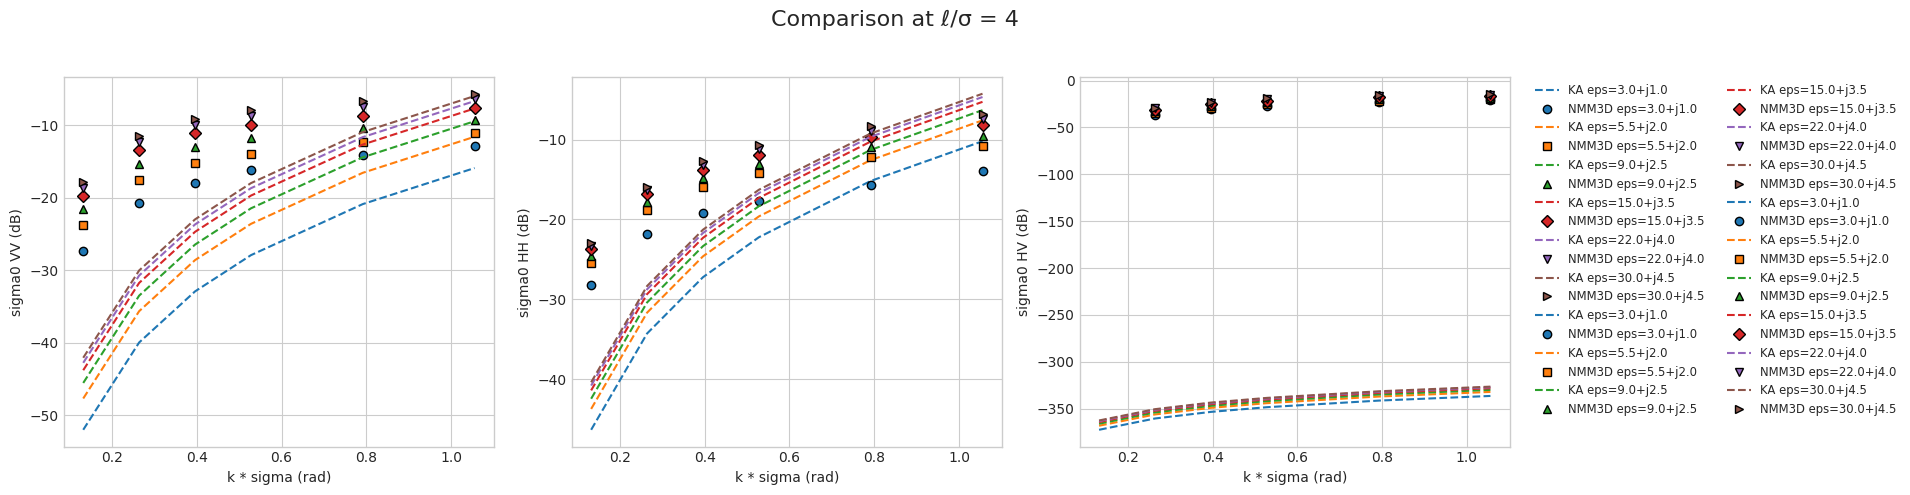

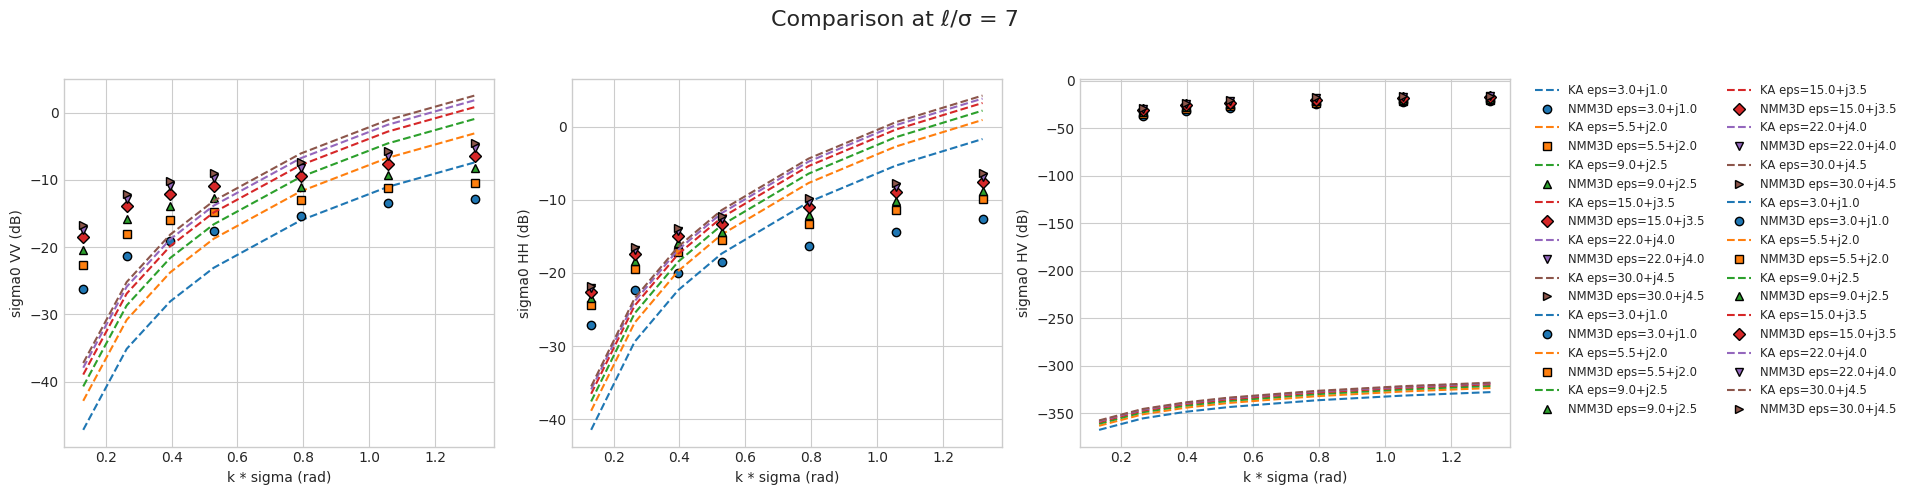

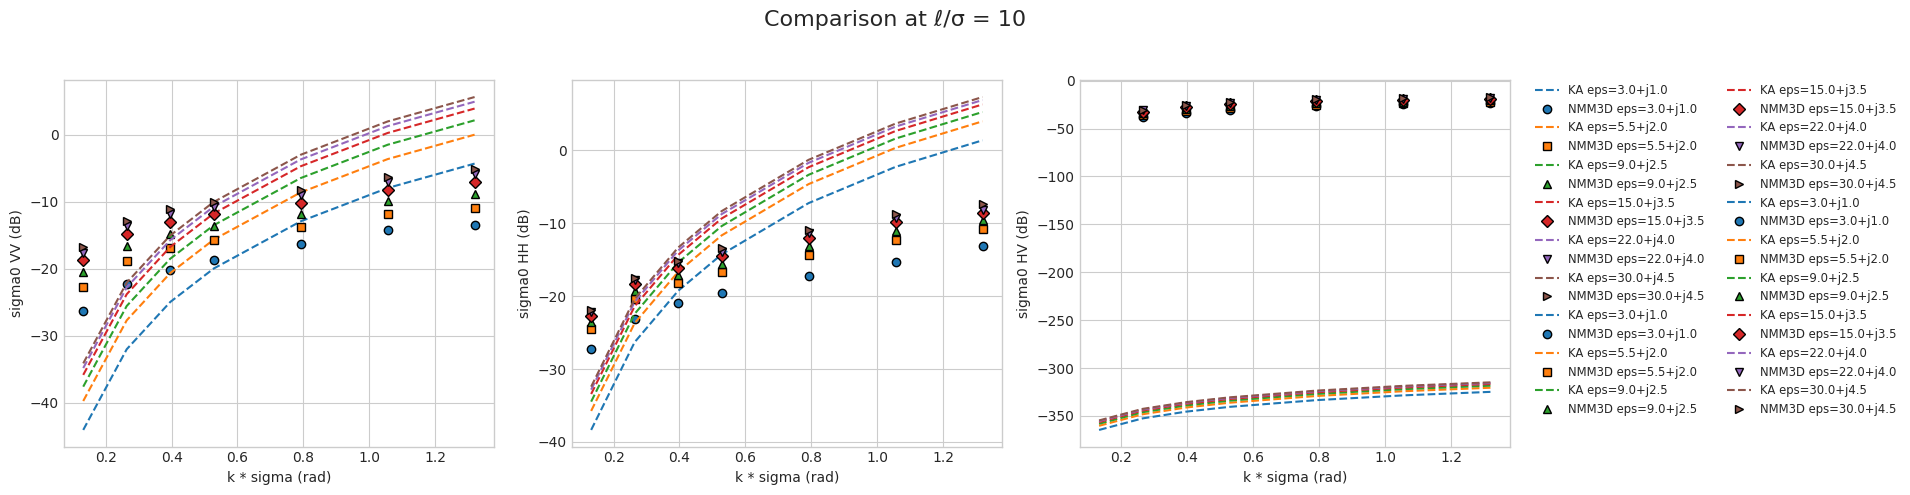

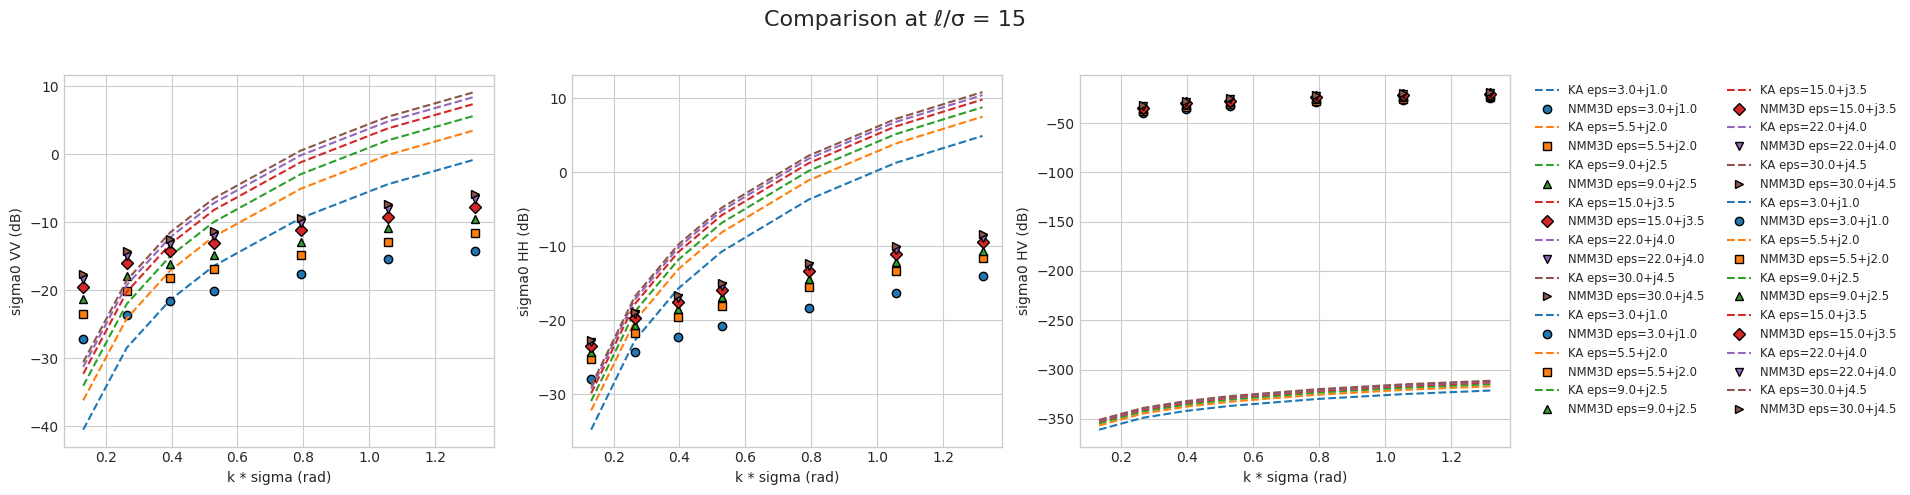

In [2]:
# Plot per ratio and polarization
unique_dielectrics = sorted({(g['eps_real'], g['eps_imag']) for g in group_results})
color_map = {die: plt.cm.tab10(i % 10) for i, die in enumerate(unique_dielectrics)}

ratio_groups = {}
for group in group_results:
    ratio_groups.setdefault(group['ratio'], []).append(group)

for ratio in sorted(ratio_groups):
    groups = ratio_groups[ratio]
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
    bands = [('vv', 'sigma0 VV (dB)'), ('hh', 'sigma0 HH (dB)'), ('hv', 'sigma0 HV (dB)')]

    handles = []
    labels = []

    for ax, (band_key, ylabel) in zip(axes, bands):
        plotted_labels = set()
        for group in groups:
            eps_pair = (group['eps_real'], group['eps_imag'])
            color = color_map[eps_pair]
            marker = MARKERS[unique_dielectrics.index(eps_pair) % len(MARKERS)]
            ks = group['ks']
            ka_vals = group[f'{band_key}_ka']
            ref_vals = group[f'{band_key}_ref']

            label_ka = f'KA eps={eps_pair[0]:.1f}+j{eps_pair[1]:.1f}'
            if label_ka not in plotted_labels:
                line, = ax.plot(ks, ka_vals, linestyle='--', color=color, label=label_ka)
                handles.append(line)
                labels.append(label_ka)
                plotted_labels.add(label_ka)
            else:
                ax.plot(ks, ka_vals, linestyle='--', color=color)

            finite_mask = np.isfinite(ref_vals)
            if np.any(finite_mask):
                label_ref = f'NMM3D eps={eps_pair[0]:.1f}+j{eps_pair[1]:.1f}'
                if label_ref not in plotted_labels:
                    pts = ax.plot(
                        ks[finite_mask],
                        ref_vals[finite_mask],
                        linestyle='none',
                        marker=marker,
                        markersize=6,
                        markerfacecolor=color,
                        markeredgecolor='black',
                        label=label_ref,
                    )[0]
                    handles.append(pts)
                    labels.append(label_ref)
                    plotted_labels.add(label_ref)
                else:
                    ax.plot(
                        ks[finite_mask],
                        ref_vals[finite_mask],
                        linestyle='none',
                        marker=marker,
                        markersize=6,
                        markerfacecolor=color,
                        markeredgecolor='black',
                    )

        ax.set_xlabel('k * sigma (rad)')
        ax.set_ylabel(ylabel)
        ax.grid(True)

    fig.suptitle(f'Comparison at ℓ/σ = {ratio:g}', fontsize=16)
    if handles:
        fig.legend(handles, labels, bbox_to_anchor=(0.85, 0.5), loc='center left', fontsize='small', ncol=2)
    fig.tight_layout(rect=[0, 0, 0.85, 0.95])
    plt.show()

## Quantitative Metrics

Statistical comparison between KA and NMM3D predictions.

In [3]:
# Metrics table
metrics_tables = []
for ratio in sorted(ratio_groups):
    groups = ratio_groups[ratio]
    rows = []
    for band, label in [('vv', 'VV'), ('hh', 'HH'), ('hv', 'HV')]:
        ref_segments = [g[f'{band}_ref'] for g in groups]
        sim_segments = [g[f'{band}_ka'] for g in groups]
        if not ref_segments:
            rows.append({
                'ratio': ratio,
                'Band': label,
                'Samples': 0,
                'RMSE (dB)': np.nan,
                'Bias (dB)': np.nan,
                'MAE (dB)': np.nan,
                'Correlation r': np.nan,
            })
            continue
        ref = np.concatenate(ref_segments)
        sim = np.concatenate(sim_segments)
        stats = compute_metrics(sim, ref)
        rows.append({
            'ratio': ratio,
            'Band': label,
            'Samples': stats['n'],
            'RMSE (dB)': stats['rmse'],
            'Bias (dB)': stats['bias'],
            'MAE (dB)': stats['mae'],
            'Correlation r': stats['r'],
        })
    metrics_tables.append(pd.DataFrame(rows))

if metrics_tables:
    metrics_df = pd.concat(metrics_tables, ignore_index=True).set_index(['ratio', 'Band'])
else:
    metrics_df = pd.DataFrame(columns=['ratio', 'Band', 'Samples', 'RMSE (dB)', 'Bias (dB)', 'MAE (dB)', 'Correlation r']).set_index(['ratio', 'Band'])

display(metrics_df)

Samples   RMSE (dB)   Bias (dB)    MAE (dB)  Correlation r
ratio Band                                                            
4.0   VV         36   14.394920  -11.978474   11.978474       0.923040
      HH         36    9.857022   -6.896745    7.949949       0.960270
      HV         30  318.166771 -318.147590  318.147590       0.978083
7.0   VV         42   10.299053   -4.789807    8.335472       0.917465
      HH         42    8.274117    0.317835    7.090787       0.965075
      HV         36  310.381531 -310.340759  310.340759       0.969979
10.0  VV         42    9.256776   -0.977482    7.744277       0.913035
      HH         42    9.488696    4.289208    8.280988       0.964823
      HV         36  305.811045 -305.769109  305.769109       0.974058
15.0  VV         42    9.852853    3.617677    8.536863       0.913008
      HH         42   12.390354    9.020080   10.887984       0.964549
      HV         36  300.359724 -300.320339  300.320339       0.980118

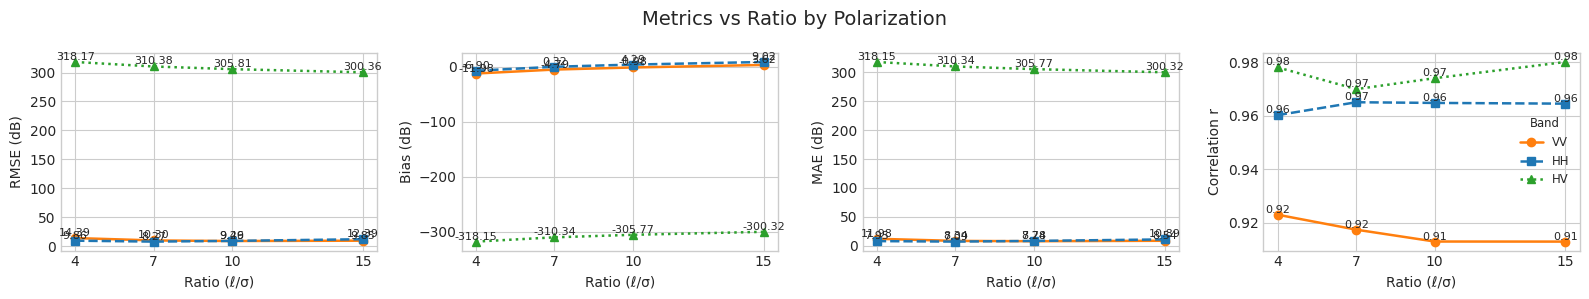

In [4]:
# Metrics plots
bands = ['VV', 'HH', 'HV']
metrics = ['RMSE (dB)', 'Bias (dB)', 'MAE (dB)', 'Correlation r']
ratios_plot = np.array(sorted(metrics_df.index.get_level_values(0).unique()))

band_styles = {
    'VV': dict(color=plt.cm.tab10(1), linestyle='-', marker='o'),
    'HH': dict(color=plt.cm.tab10(0), linestyle='--', marker='s'),
    'HV': dict(color=plt.cm.tab10(2), linestyle=':', marker='^'),
}

fig, axes = plt.subplots(1, len(metrics), figsize=(16, 3))
fig.suptitle('Metrics vs Ratio by Polarization', fontsize=14)

for i, metric in enumerate(metrics):
    ax = axes[i]
    for band in bands:
        vals = []
        for r in ratios_plot:
            try:
                vals.append(float(metrics_df.loc[(r, band), metric]))
            except Exception:
                vals.append(np.nan)
        vals = np.array(vals, dtype=float)
        style = band_styles[band]
        ax.plot(
            ratios_plot,
            vals,
            label=band,
            color=style['color'],
            linestyle=style['linestyle'],
            marker=style['marker'],
            linewidth=1.8,
            markersize=6,
        )
        for x, y in zip(ratios_plot, vals):
            if np.isfinite(y):
                ax.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=8)

    ax.set_ylabel(metric, fontsize=10)
    ax.set_xlabel('Ratio (ℓ/σ)')
    ax.set_xticks(ratios_plot)

    if i == len(metrics) - 1:
        ax.legend(title='Band', fontsize='small', title_fontsize='small')

fig.tight_layout()
plt.show()

## Scatter Plots

Direct comparison of KA vs NMM3D predictions. Points on the diagonal indicate perfect agreement.

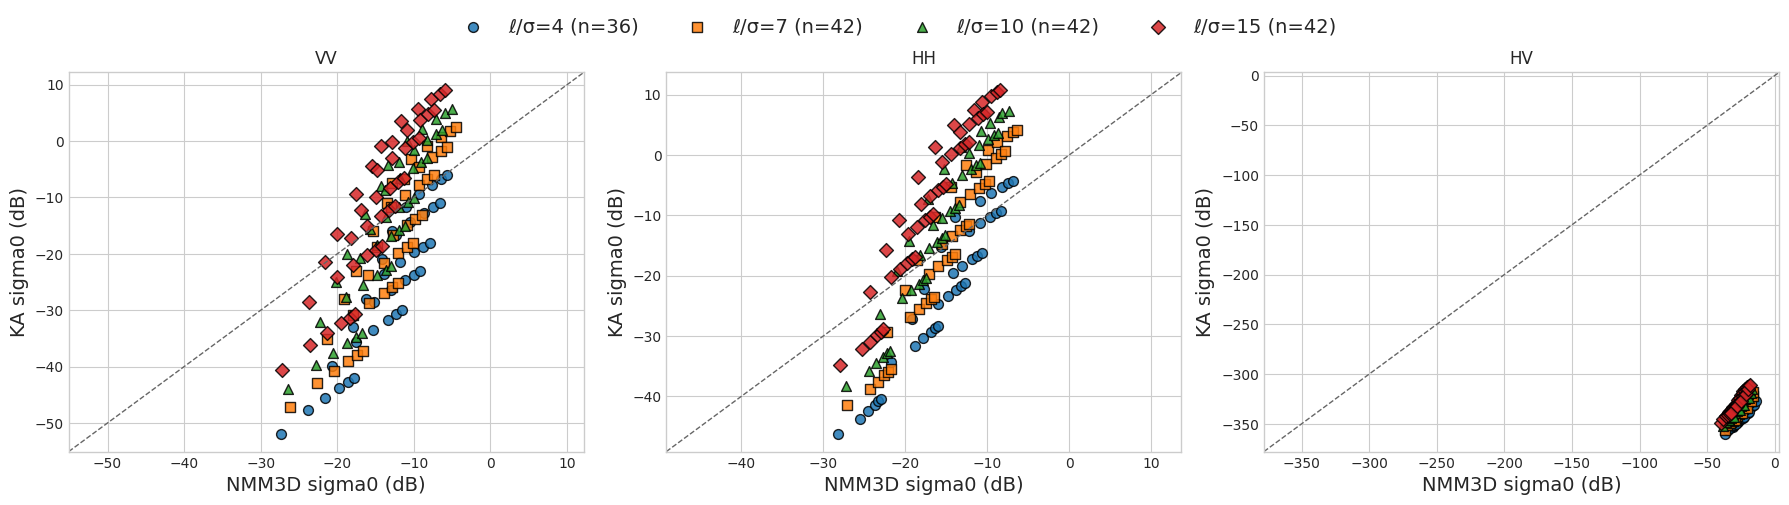

In [5]:
# Scatter plots
ratios = sorted(ratio_groups.keys())
markers = list(MARKERS.values())
colors = [plt.cm.tab10(i % 10) for i in range(len(ratios))]

bands = [('vv', 'VV'), ('hh', 'HH'), ('hv', 'HV')]
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=False, sharey=False)

extents = {bkey: [np.inf, -np.inf] for bkey, _ in bands}

for i, ratio in enumerate(ratios):
    groups = ratio_groups[ratio]
    marker = markers[i % len(markers)]
    color = colors[i]
    for ax_idx, (bkey, bname) in enumerate(bands):
        ref_segs = [g[f'{bkey}_ref'] for g in groups]
        sim_segs = [g[f'{bkey}_ka'] for g in groups]
        if not ref_segs or not sim_segs:
            continue
        ref = np.concatenate(ref_segs)
        sim = np.concatenate(sim_segs)
        mask = np.isfinite(ref) & np.isfinite(sim)
        if not np.any(mask):
            continue
        ax = axes[ax_idx]
        ax.scatter(
            ref[mask],
            sim[mask],
            label=f'ℓ/σ={ratio:g} (n={mask.sum()})',
            color=color,
            marker=marker,
            edgecolor='black',
            alpha=0.85,
            s=50,
        )
        combined_min = min(np.nanmin(ref[mask]), np.nanmin(sim[mask]))
        combined_max = max(np.nanmax(ref[mask]), np.nanmax(sim[mask]))
        extents[bkey][0] = min(extents[bkey][0], combined_min)
        extents[bkey][1] = max(extents[bkey][1], combined_max)

for ax_idx, (bkey, bname) in enumerate(bands):
    ax = axes[ax_idx]
    lo, hi = extents[bkey]
    if not np.isfinite(lo) or not np.isfinite(hi):
        ax.autoscale()
    else:
        pad = 0.05 * (hi - lo) if hi > lo else 1.0
        ax.set_xlim(lo - pad, hi + pad)
        ax.set_ylim(lo - pad, hi + pad)
        ax.plot([lo - pad, hi + pad], [lo - pad, hi + pad], color='0.4', linestyle='--', linewidth=1)
    ax.set_xlabel('NMM3D sigma0 (dB)', fontsize=14)
    ax.set_ylabel('KA sigma0 (dB)', fontsize=14)
    ax.set_title(bname)
    ax.grid(True)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=min(len(ratios), 6), bbox_to_anchor=(0.5, 1.02), fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Summary

**Key Observations:**

1. **Co-polarization (VV/HH)**: KA captures the general trend but may underestimate backscatter for surfaces outside its validity range.

2. **Cross-polarization (HV)**: KA predicts near-zero cross-pol for monostatic backscatter, which is theoretically correct for single-bounce specular reflection. NMM3D includes multiple scattering and small-scale roughness effects.

3. **Validity Range**: Best agreement occurs when:
   - k·σ > 1 (rough surface)
   - k·L > 10 (large correlation length)
   - MSS < 0.3 (moderate slopes)

4. **Model Selection**:
   - Use **KA** for large-scale roughness (ocean waves, terrain)
   - Use **SPM** for smooth surfaces (k·σ < 0.3)
   - Use **IEM/AIEM** for intermediate roughness
   - Use **two-scale models** for realistic surfaces with multiple scales

**References:**
- See `docs/KA_MODEL_ACFs.md` for complete mathematical derivation
- See `src/mwrtms/scattering/surface/ka.py` for implementation details